
Hello this is a Neural network for a trivial task with the mnist dataset

In [14]:
import numpy as np
import struct
from array import array
from os.path  import join
import matplotlib.pyplot as plt



class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
    # Read labels
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        

        # Read images
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())

        images = []
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(rows, cols)  
            images.append(img)

        return images, labels
    
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)       


This section demonstrates how to load the MNIST dataset using a custom data loader, visualize random training and test images, and plot the distribution of digit labels.

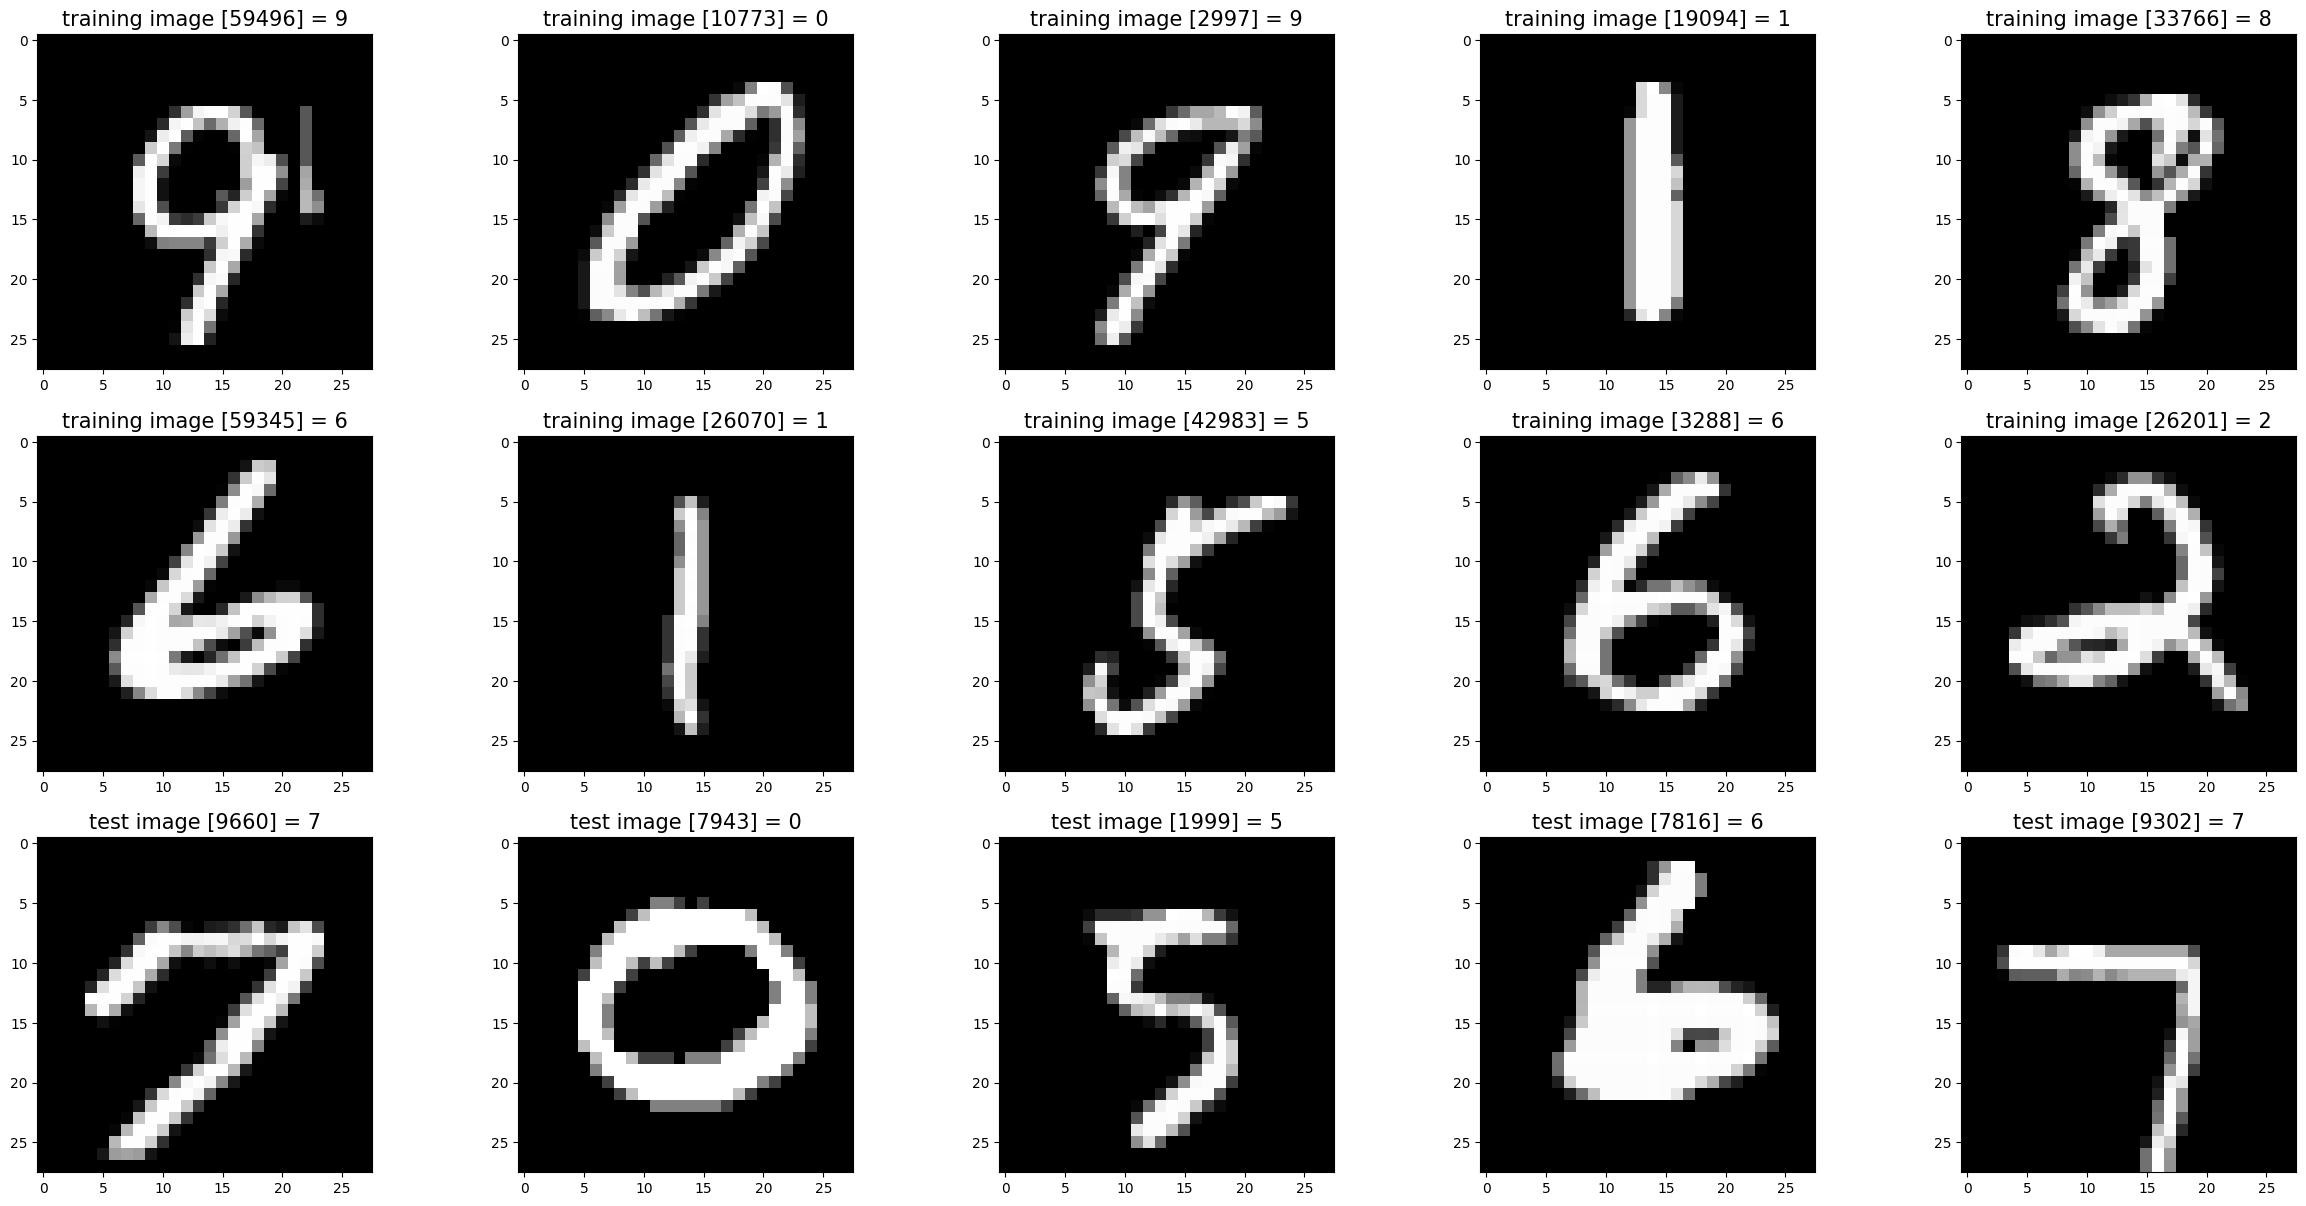

In [15]:
import random
import matplotlib.pyplot as plt # type: ignore


input_path = r'D:\Datasets\mnist' 
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

# Help function to show a list of images with their relating titles, mostly for verification

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()


# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

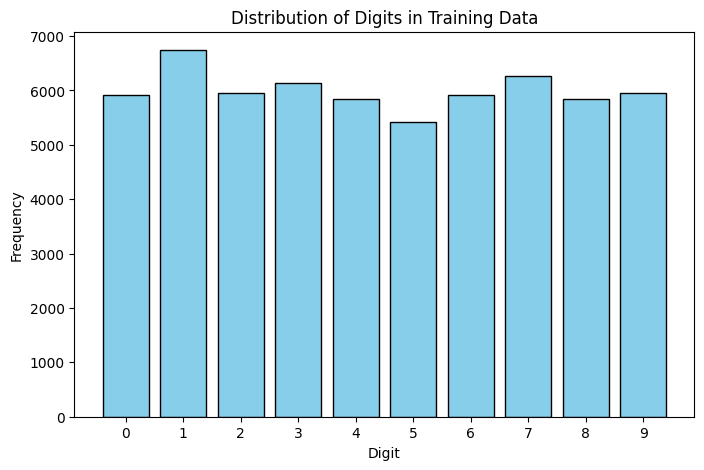

In [16]:
y_train = np.array(y_train)

#frequency of each digit
digits = np.arange(10)
frequency = [np.sum(y_train == d) for d in digits]
#bar graph
plt.figure(figsize=(8, 5))
plt.bar(digits, frequency, color='skyblue', edgecolor='black')
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.title('Distribution of Digits in Training Data')
plt.xticks(digits)
plt.show()

Before training, each MNIST image is normalized and flattened. This is handled by two helper functions:

preprocess_images(images):
Converts a list of 2D images into a 2D NumPy array where each image is flattened (28×28 becomes 784) and the pixel values are normalized to the range [0, 1].

one_hot_encode(labels, num_classes=10):
Converts a list of integer labels into one‑hot encoded vectors. For example, the label 3 becomes [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].

In [19]:
import cupy as cp

def preprocess_images(images):
    # images kan vara NumPy- eller CuPy-array; vi konverterar till CuPy direkt
    images_cp = cp.asarray(images, dtype=cp.float32)
    num_images = images_cp.shape[0]
    # Förflattening och skalning till [0,1]
    processed = images_cp.reshape(num_images, -1) / 255.0
    return processed

def one_hot_encode(labels, num_classes=10):
    labels_cp = cp.asarray(labels, dtype=cp.int32)
    num_labels = labels_cp.shape[0]
    one_hot = cp.zeros((num_labels, num_classes), dtype=cp.float32)
    # Sätter en etta i rätt kolumn för varje rad
    one_hot[cp.arange(num_labels), labels_cp] = 1
    return one_hot

# Kör preprocessing
x_train_processed = preprocess_images(x_train)  # CuPy-array (N_train, 784)
x_test_processed  = preprocess_images(x_test)   # CuPy-array (N_test, 784)

# One-hot-encode labelsen
y_train_encoded = one_hot_encode(y_train, num_classes=10)  # CuPy-array (N_train, 10)
y_test_encoded  = one_hot_encode(y_test,  num_classes=10)  # CuPy-array (N_test, 10)

# Skapa valideringsuppsättning
n_samples = x_train_processed.shape[0]
VALIDATION_SPLIT = 0.2

# Slumpa indices
perm = cp.random.permutation(n_samples)
x_shuffled = x_train_processed[perm]
y_shuffled = y_train_encoded[perm]

# Dela upp i tränings- och valideringsset
split_idx = int(n_samples * (1.0 - VALIDATION_SPLIT))
x_ctrain, y_ctrain = x_shuffled[:split_idx], y_shuffled[:split_idx]
x_val,    y_val    = x_shuffled[split_idx:],  y_shuffled[split_idx:]



AttributeError: attribute '__name__' of 'builtin_function_or_method' objects is not writable

The network is implemented from scratch using NumPy. It includes:
Xavier Initialization for the weights.
A sigmoid activation in the hidden layer.
A softmax activation in the output layer to produce class probabilities
Cross-Entropy Loss used during training.
A simple backpropagation routine to update weights and biases.

In [ ]:


def relu(x):
    return cp.maximum(0, x)
        
def relu_derivative(x):
    return cp.where(x > 0, 1, 0)
        
def softmax(x):
    # För numerisk stabilitet: subtrahera max per rad
    exp_x = cp.exp(x - cp.max(x, axis=1, keepdims=True))
    return exp_x / cp.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    eps = 1e-12
    y_pred = cp.clip(y_pred, eps, 1.0 - eps)
    m = y_true.shape[0]
    loss = -cp.sum(y_true * cp.log(y_pred)) / m
    return loss

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Xavier-init
        limit_hidden = cp.sqrt(6 / (input_size + hidden_size))
        self.weights_hidden_input = cp.random.uniform(-limit_hidden, limit_hidden, (input_size, hidden_size))
        limit_output = cp.sqrt(6 / (hidden_size + output_size))
        self.weights_hidden_output = cp.random.uniform(-limit_output, limit_output, (hidden_size, output_size))
        
        # biases
        self.bias_hidden = cp.zeros((1, hidden_size))
        self.bias_output = cp.zeros((1, output_size))

    def forward(self, x):
        # x antas vara en CuPy-array
        self.hidden_input = cp.dot(x, self.weights_hidden_input) + self.bias_hidden
        self.hidden_output = relu(self.hidden_input)
        self.final_input = cp.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
        self.final_output = softmax(self.final_input)
        return self.final_output

    def backward(self, x, y, learning_rate):
        m = y.shape[0]

        delta_output = (self.final_output - y) / m

        grad_weights_hidden_output = cp.dot(self.hidden_output.T, delta_output)
        grad_bias_output = cp.sum(delta_output, axis=0, keepdims=True)

        delta_hidden = cp.dot(delta_output, self.weights_hidden_output.T) * relu_derivative(self.hidden_output)

        grad_weights_hidden_input = cp.dot(x.T, delta_hidden)
        grad_bias_hidden = cp.sum(delta_hidden, axis=0, keepdims=True)

        # uppdatera
        self.weights_hidden_output -= learning_rate * grad_weights_hidden_output
        self.bias_output            -= learning_rate * grad_bias_output
        self.weights_hidden_input  -= learning_rate * grad_weights_hidden_input
        self.bias_hidden           -= learning_rate * grad_bias_hidden

    def train(self, x_train, y_train, x_val, y_val, learning_rate, epochs):
        # flytta data till GPU om det är NumPy-arrayer
        if not isinstance(x_train, cp.ndarray):
            x_train = cp.asarray(x_train)
            y_train = cp.asarray(y_train)
            x_val   = cp.asarray(x_val)
            y_val   = cp.asarray(y_val)

        self.train_losses = []
        self.train_accs   = []
        self.val_losses   = []
        self.val_accs     = []

        y_train_idx = cp.argmax(y_train, axis=1)
        y_val_idx   = cp.argmax(y_val,   axis=1)

        for epoch in range(1, epochs+1):
            y_pred_train = self.forward(x_train)
            loss_train = cross_entropy_loss(y_train, y_pred_train)
            acc_train = cp.mean(cp.argmax(y_pred_train, axis=1) == y_train_idx)

            self.backward(x_train, y_train, learning_rate)

            self.train_losses.append(loss_train.get())
            self.train_accs.append(acc_train.get())

            # val pass
            y_pred_val = self.forward(x_val)
            loss_val = cross_entropy_loss(y_val, y_pred_val)
            acc_val = cp.mean(cp.argmax(y_pred_val, axis=1) == y_val_idx)

            self.val_losses.append(loss_val.get())
            self.val_accs.append(acc_val.get())

            if epoch % 50 == 0 or epoch == 1:
                # .get() för att få ut scalarn till CPU för print
                print(f"Epoch {epoch:03d} │ "
                      f"train_loss {loss_train.get():.4f}, train_acc {acc_train.get():.3f} │ "
                      f"val_loss   {loss_val.get():.4f},   val_acc   {acc_val.get():.3f}")

        


In [ ]:

#Load MNIST
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, 
                                   test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Preprocess the images: flatten and normalize
x_train_processed = preprocess_images(x_train)
x_test_processed = preprocess_images(x_test)

# One-hot encode labels for the classification (we use 10 because MNIST goes from 0-9)
y_train_encoded = one_hot_encode(y_train, num_classes=10)
y_test_encoded = one_hot_encode(y_test, num_classes=10)

input_size = 28 * 28     # Each image is 28x28 pixels
hidden_size = 400         # might change hidden size
output_size = 10         # 10 classes for digits 0-9

# Instantiate the neural network
nn = NeuralNetwork(input_size, hidden_size, output_size)

# Training hyperparameters
learning_rate = 0.005
epochs = 500

# Start training
nn.train(x_ctrain, y_ctrain, x_val, y_val, learning_rate=learning_rate, epochs=epochs)

# Post training, single compute
test_proba       = nn.forward(x_test_processed)
predicted_labels = np.argmax(test_proba, axis=1)
y_true           = np.array(y_test)



Epoch 001 │ train_loss 2.4059, train_acc 0.069 │ val_loss   2.4016,   val_acc   0.069
Epoch 050 │ train_loss 2.1075, train_acc 0.339 │ val_loss   2.1036,   val_acc   0.339
Epoch 100 │ train_loss 1.8857, train_acc 0.593 │ val_loss   1.8828,   val_acc   0.593
Epoch 150 │ train_loss 1.6954, train_acc 0.692 │ val_loss   1.6943,   val_acc   0.692
Epoch 200 │ train_loss 1.5279, train_acc 0.740 │ val_loss   1.5288,   val_acc   0.740
Epoch 250 │ train_loss 1.3819, train_acc 0.770 │ val_loss   1.3847,   val_acc   0.770
Epoch 300 │ train_loss 1.2566, train_acc 0.787 │ val_loss   1.2611,   val_acc   0.787
Epoch 350 │ train_loss 1.1502, train_acc 0.801 │ val_loss   1.1562,   val_acc   0.801
Epoch 400 │ train_loss 1.0605, train_acc 0.812 │ val_loss   1.0676,   val_acc   0.812
Epoch 450 │ train_loss 0.9848, train_acc 0.819 │ val_loss   0.9930,   val_acc   0.819
Epoch 500 │ train_loss 0.9209, train_acc 0.826 │ val_loss   0.9299,   val_acc   0.826


Sample predicted labels: [7 2 1 0 4 1 4 9 6 9]


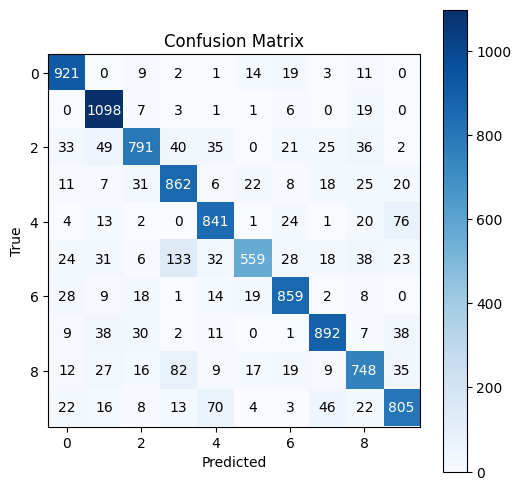

Per-Class Accuracies: {0: np.float64(0.939795918367347), 1: np.float64(0.9674008810572687), 2: np.float64(0.7664728682170543), 3: np.float64(0.8534653465346534), 4: np.float64(0.8564154786150713), 5: np.float64(0.6266816143497758), 6: np.float64(0.8966597077244259), 7: np.float64(0.867704280155642), 8: np.float64(0.7679671457905544), 9: np.float64(0.7978196233894945)}
Macro F1 Score: 0.8335084266565529

Top‑2 accuracy: 0.9238
Top‑3 accuracy: 0.9577


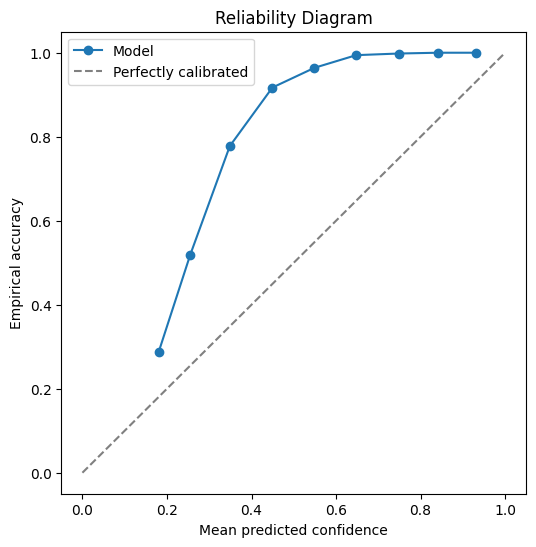

In [ ]:
# See the final predictions on some test data:
test_predictions = nn.forward(x_test_processed)
predicted_labels = np.argmax(test_predictions, axis=1)
print("Sample predicted labels:", predicted_labels[:10])

#return accuracy for each individual class.
def per_class_accuracy(y_true, y_pred, num_classes=10):
    acc_dict = {}
    for cls in range(num_classes):
        cls_idx = (y_true == cls)
        if np.sum(cls_idx) > 0:
            acc = np.sum(y_pred[cls_idx] == cls) / np.sum(cls_idx)
            acc_dict[cls] = acc
        else:
            acc_dict[cls] = None  # In case a class is missing
    return acc_dict

y_true = np.array(y_test)
per_class_acc = per_class_accuracy(y_true, predicted_labels, num_classes=10)

# Confusion matrix
num_classes = 10
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(y_true, predicted_labels):
    cm[t, p] += 1

plt.figure(figsize=(6,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i,j], ha="center", va="center", color="white" if cm[i,j]>cm.max()/2 else "black")
plt.show()

print("Per-Class Accuracies:", per_class_acc)

def f1_multiclass(y_true, y_pred, average='macro'):
    classes = np.unique(y_true)
    f1_scores = {}
    precisions = {}
    recalls = {}

    for cls in classes:
        tp = np.sum((y_true == cls) & (y_pred == cls))
        fp = np.sum((y_true != cls) & (y_pred == cls))
        fn = np.sum((y_true == cls) & (y_pred != cls))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        f1_scores[cls] = f1
        precisions[cls] = precision
        recalls[cls] = recall
    
    if average == 'macro':
        f1_avg = np.mean(list(f1_scores.values()))
    elif average == 'weighted':
        support = {cls: np.sum(y_true == cls) for cls in classes}
        total = len(y_true)
        f1_avg = sum(f1_scores[cls] * support[cls] for cls in classes) / total
    else:
        raise ValueError("Average must be 'macro' or 'weighted'")
        
    return f1_avg, f1_scores, precisions, recalls

y_true = np.array(y_test)
f1_macro, f1_per_class, precision_per_class, recall_per_class = f1_multiclass(y_true, predicted_labels, average='macro')
print("Macro F1 Score:", f1_macro)

# Top k acc
def top_k_accuracy(y_true, y_proba, k=2):
    topk = np.argsort(y_proba, axis=1)[:, -k:]
    return np.mean([y_true[i] in topk[i] for i in range(len(y_true))])

print(f"\nTop‑2 accuracy: {top_k_accuracy(y_true, test_proba, k=2):.4f}")
print(f"Top‑3 accuracy: {top_k_accuracy(y_true, test_proba, k=3):.4f}")


# Reliability curve
confidences = test_proba.max(axis=1)
correct     = (predicted_labels == y_true).astype(int)
n_bins      = 10
bin_edges   = np.linspace(0, 1, n_bins+1)
prob_true, prob_pred = [], []

for i in range(n_bins):
    mask = (confidences >= bin_edges[i]) & (confidences < bin_edges[i+1])
    if mask.any():
        prob_pred.append(confidences[mask].mean())
        prob_true.append(correct[mask].mean())
    else:
        prob_pred.append((bin_edges[i]+bin_edges[i+1])/2)
        prob_true.append(np.nan)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, "o-", label="Model")
plt.plot([0,1],[0,1],"--", color="gray", label="Perfectly calibrated")
plt.title("Reliability Diagram")
plt.xlabel("Mean predicted confidence")
plt.ylabel("Empirical accuracy")
plt.legend()
plt.show()

In [ ]:
def save_model(nn, filename="custom_nn_weights.npz"):
    np.savez(filename,
             weights_hidden_input=nn.weights_hidden_input,
             weights_hidden_output=nn.weights_hidden_output)
    print(f"Model weights saved to {filename}")

# save the weights after training
save_model(nn)

Model weights saved to custom_nn_weights.npz
